<a href="https://colab.research.google.com/github/Leja-skywalker/GEOV212_exercise_2_LH/blob/main/Exercise_2_steady_state_groundwater_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 2: Modelling steady-state groundwater flow with python

February 2026

Elco Luijendijk - <elco.luijendijk@uib.no> and Josse van den Berg


## Objectives

* Learn how to solve simple 1D steady-state groundwater flow with Python instead of Excel, by converting our Excel model to Python

**What to hand in**. Hand in a version of your jupyter notebook and a short word document with answers to the assignments and the result figures of your numerical model.

**Grading**: Each assignment is 1 point, for a total of 4 points.

Do not hesitate to ask questions if you get stuck anywhere. You can reach me by email, on mitt.uib or pass by at my office on the 2nd floor.

*Good luck !*

## Loading modules

First the notebook contains some lines to import all the external modules that we need for this exercise. For this exercise we need numpy, for working with arrays, and matplotlib, to make some nice looking figures. For a nice overview of all the different graphics you can make with python head over to the matplotlib website: https://matplotlib.org/

Note that any line starting with # is a comment and is ignored by Python. Try adding comments in your code to make reading the code and figuring out what it does easier later on. In the next lines we import the modules numpy and pyplot, which is part of matplotlib. We also specified ``as np``, which means that any numpy command we use must start with ``np.``, for example to take the square root of a number using numpy we should type ``np.sqrt(9)``. For pyplot we have to use the prefix ``pl.``. For example the following command: ``pl.plot([0, 2], [0, 2])`` will plot a straight line from (0, 0) to (2, 2).


In [ ]:
# importing external python modules

# numpy for working with arrays:
import numpy as np
# and matplotlib to make nice looking figures
import matplotlib.pyplot as pl

import scipy.optimize as opt

## Introduction
In this exercise we will use the programming language Python to solve the groundwater and heat flow equations in 1D. We will solve the same groundwater flow equation as in exercise 1, make some figures of the model output and use automated calibration to explore the effect of measurement errors of hydraulic head on calibrated values of hydraulic conductivity.

## Parameters


As in exercise 1, we will again set up a numerical model that represents a simplified version of the typical global average watershed, using the simple conceptual model shown in the figure below. First, we will set the parameters.

The parameters are given in the following table:

| L (m) |  b (m) |  h0 (m) |  R (m/yr) |  K (m/s)  | $\Delta x$ (m) |
| ----- | ------ | ------- | --------- | --------- | -------------- |  
| 5000  |  250   |   250   | 0.25      | $10^{-5}$ | 100            |

Note that it is a good habit to use decimal points to distinguish floating point numbers from integers, so ``L=5000.0`` instead of ``L=5000``. In the last case Python will assume L is an integer (ie, a whole number), which may result in counter-intuitive behaviour when using L in calculations later on.

Also note that all parameters should be given in SI units (i.e. meters, seconds, kg). To convert recharge from m/yr to m/s add something like this:

~~~~python
R = 0.25 / (365.25 * 24 * 60 * 60)
~~~~

go ahead and add all parameters that we need in the cell below

In [10]:
year = 365.25 * 24 * 60 * 60.0

# add all the model parameters that you need:
R = 0.25 / (365.25 * 24 * 60 * 60)
L = 5000
dx = 100
b = 250
h0 = 250
K = 1e-5

After specifying all input parameters we need to calculate the fluid source term (*W*) using the equation given in exercise 1: $W = (R * \Delta x / (\Delta x * b))$:


In [24]:
W = (R * dx/(dx*b))

### Setting up arrays

For a number of variables like distance (x) and the source term (W) we need to set up arrays, ie. rows of numbers. This is similar to the columns of numbers that you used in your numerical model in excel. The following line will set up an array that represents distance (x):

~~~~python
x = np.arange(0, L + dx, dx)
~~~~

This generates an array that starts with 0, ends with the value ``L`` and has ``(L/dx + 1)`` nodes. For the source term W we can set up an array with the same length as array ``x`` in this way:

~~~~python
W_array = np.ones_like(x) * W
~~~~

This creates a new array with the same length as x. This new array is filled with the number one and then multiplied by the value of the source term (*W*) that we just calculated before.

Now go ahead and run the code below to set up the arrays that we need:


In [25]:
# calculate the position of each node:
x = np.arange(0, L + dx, dx)

# set up an array with a source term for each node
W_array = np.ones_like(x) * W

Next we will check the content of the arrays that we have just set up:

In [ ]:
print('the array x contains the following numbers: ', x)
print('and W_array contains:', W_array)

Note that you can also select parts of arrays, as shown in the Python tutorial.
For instance to find the first value of x we can type the following:

In [ ]:
x[0]

Note that Python always starts counting at 0.
You can also start counting at the end by using negative numbers.
The last value of x can be found using:

In [ ]:
x[-1]

and finally you can also select ranges of numbers. To select all values of x except the first and the last you can type:

In [13]:
x[1:-1]

array([ 100,  200,  300,  400,  500,  600,  700,  800,  900, 1000, 1100,
       1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200,
       2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200, 3300,
       3400, 3500, 3600, 3700, 3800, 3900, 4000, 4100, 4200, 4300, 4400,
       4500, 4600, 4700, 4800, 4900])

Numpy array indexing examples:
- `x[0]` - first element
- `x[-1]` - last element
- `x[-2]` - second-to-last element
- `x[1:-1]` - all elements except first and last
- `x[2:]` - all elements from index 2 onwards
- `x[:-2]` - all elements except the last two

## Set up a numerical model in Python

Next, we will solve the 1-dimensional form of the groundwater flow equation (also, see your handout for exercise 1):

$$h(x) = \frac{1}{2} \left( \frac{Wb \Delta x^2}{K b} + h(x+\Delta x) + h(x - \Delta x) \right)$$

### Python functions

Next up there is a section that starts with ``def solve_steady_state_diffusion(...)``. This is a function. A function is an isolated part of the script that uses a set of input variables, does some operations with these variables (like solving the groundwater flow eq.) and returns one or more variables to the main script. You will need to adjust the function below later. For now lets skip the function and scroll down to the main part of the code.

Note that Python uses indents (empty spaces) to determine which part of the code belongs to which function or loop. This means that all indented code below the start of the function belongs to the function. You can add indents using the tab key.

~~~python
# an example of indentation:

# this line is not indented
    # this line is indented
~~~


### Using the steady-state diffusion eq. function:

You will find the equation(`solve_steady_state_diffusion_eq`) below, this solves the steady-state groundwater equation.

However, the function is not complete yet. If you go through the function you will notice a few lines that still have to be completed. The function starts with creating two new arrays, ``h_new`` and ``h_old``. These store the value of the variable you are trying to solve, which in this case is hydraulic head. The function solves the equation iteratively. After each iteration time step the newly calculated value ``h_new`` is copied to ``h_old`` and the iteration is repeated.

The iterations are executed using a so called for loop. The following line:

~~~~python
for n_iter in range(n_iterations):
~~~~

means that any code that is below this line and that is indented is repeated ``n_iterations`` times.

There is a second for loop that is inside the first for loop, which makes sure we go over each node in our model:

~~~~python
    # set up a for loop to repeat the calculation n_iterations times
    for n_iter in range(n_iterations):
        
        # set up a new for loop to go through all the grid cells:
        for i in range(n_nodes):
~~~~

The code in this second for loop does the actual calculation of the hydraulic head for each node and each iteration.

We have to make sure that the groundwater flow equation is solved correctly. There are three lines to complete in the function, one where the hydraulic head at the left hand side of the model domain is calculated, one that calculates value on the right hand side of the model domain, and one where you calculate hydraulic head in the remaining nodes in the middle.

Now go ahead and try to complete the line starting with ``#u_new[0] = ``:

~~~~python
# check if we are at the left-hand boundary of the model domain
if i == 0:
    # complete the next line and remove the comment sign (#)
    #h_new[0] = ....
~~~~

the variable ``h_new[0]`` means the value of ``h_new`` at the first node, which has node number 0. Note that python always starts to count at 0, and not 1 like for instance in Matlab. In exercise 1 we assigned a specified hydraulic head to the first node. The specified head is passed to the function as the variable ``h0``.

Next we can try to complete the line for the nodes in the middle:

~~~~python
else:
    # add the equation for the middle nodes here:
    #h_new[i] = ..... a function of C[i], h_old[i-1] and h_old[i+1]
~~~~

Look up the correct equation in your handout, modify the line and remove the # sign before the line to make it active. `h_new[i]` means the value of `h_new` at node number `i`. Note that i is part of the for loop: ``for i in range(n_nodes):``. This means that everything below this loop is repeated and `i` is increased with one after completing each loop. ``h_old[i-1]`` means the value of `h_old` at node number `i-1`, which is the node before node `i`. And similarly ``h_old[i+1]`` means the value of `h_old` at node `i+1`, the next node.

Next we have to make sure that the right hand boundary acts as a no flow boundary. In Excel we did this by making sure that the hydraulic head at a imaginary ghost grid cell one row below the last grid cell always had the same value as the last grid cell. In python we can do the same by making sure that the value in the last node (``h_new[-1]``) is always the same as the second last node (``h_new[-2]``):

~~~~python
    # check if we are at the right hand boundary instead
    elif i == n_nodes - 1:
        # complete the next line and remove the comment sign (#)
        #h_new[-1] = .... a function of h_old[-2]
~~~~

The index ``[-1]`` is shorthand for the last item in an array. So ``h_new[-1]`` is the value of hydraulic head for the right most grid cell, and ``h_new[-2]`` is the second last node, etc...


Note that the term $\dfrac{Wb \Delta x^2}{K b}$ of the groundwater flow equation only needs to be calculated once and therefore can be kept outside the iteration loop. The term $\frac{Wb \Delta x^2}{K b}$ is stored in a new variable called ``C``.

In [28]:
def solve_steady_state_diffusion_eq(dx, K, W, h0, n_iterations=1000):

    """
    this is a function where we will solve the steady-state diffusion equation
    for groundwater or heat flow

    this function receives 4 variables from the main code: dx, K, W, u0
    plus an optional variable n_iterations. The default value for this
    variable if not specified otherwise is 1000

    """

    # checking the number of nodes in our numerical model:
    n_nodes = len(W)

    # set u an array to store the variable (ie, hydraulic head or temperature)
    h_new = np.full(n_nodes, h0)

    # and set up a similar array to store the variable value of the previous
    # iteration step
    h_old = h_new.copy()

    # calculate the right hand term of the finite difference equation:
    C = W * dx**2 / K

    # set up a for loop to repeat the calculation n_iterations times
    for n_iter in range(n_iterations):

        # set up a new for loop to go through all the grid cells:
        for i in range(n_nodes):

            # check if we are at the left-hand boundary of the model domain,
            # fixed head
            if i == 0:
                h_new[0] = h0;

            #if not a boundary
            elif i != n_nodes - 1:
                # add the equation for the middle nodes here:
                h_new[i] = (h_old[i-1] + h_old[i+1] + C[i]) / 2

            # check if we are at the right hand boundary instead, no-flow
            else:
                # complete the next line and remove the comment sign (#)
                h_new[-1] = h_new[-2]


        # copy the new u into the u array for the previous timestep:
        h_old = h_new.copy()

    # done, you can now pass on the calculated value of u back to the main
    # part of the code:
    return h_new

## Running the model

Make sure you complete and run the diffusion function above and that the jupyter notebook does not generate an error if you do so. The reason is usually a typo or a wrong indentation. Try to fix this or call for help from your instructor if you cannot figure out the error.

Now try to run the model code by running the cell below. Watch the values of h increase towards a steady-state value (hopefully). Increase the number of iterations in the function if you need more steps to reach steady-state.

In [29]:
# call the steady-state diffusion function to calculate h
h = solve_steady_state_diffusion_eq(dx, K, W_array, h0)
print(h[10:20])


[250 250 250 250 250 250 250 250 250 250]


If everything works ok: congrats! You can inspect the modelled values of hydraulic head by making a new code cell by slecting the plus button above, and typing ``print(h)`` in this cell. Your values, after a 1000 iterations (standard) will be values in a range from 250 to 264. If you want to only see part of the h array (which contains the modeled hydraulic head), you can for instance type ``print(h[10:20])`` to see the values of h for node 10 to 20 or ``print(h[-1])`` to check the value at the last grid cell.

If the code does not work: Do not panic. Go over your code to make sure there are no typos etc, you did not forget to define any variables, indentations are ok, etc... If the code is still not behaving: try to get the attention of your instructor or shout help.

I think that visualising helps, use the code below so that you can see the results. Making nice-looking figures with Python is very easy thanks to the matplotlib module that we have imported already. For an overview of what you can do with matplotlib surf to the website and look at the gallery: <http://matplotlib.org/gallery.html>.


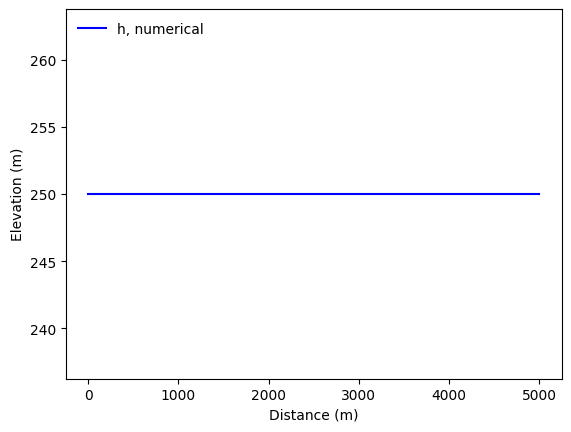

In [30]:
# set up a figure with one panel
fig, panel = pl.subplots(1, 1)

# plot the numerical solution
panel.plot(x, h, color='blue', label='h, numerical')

# make the figure nicer:
panel.set_xlabel('Distance (m)')
panel.set_ylabel('Elevation (m)')
panel.legend(loc='upper left', fontsize='medium', frameon=False)


## Adding the analytical solution

One good habit when running numerical models is to try and always find an analytical solution to test whether your numerical model is behaving well. Try to implement the analytical solution for the groundwater table that was shown in exercise 1.
$h(x) = h_0 + \frac{R}{K b} \left( L x - \frac{1}{2} x^2 \right)$

Complete the line that starts with ``#h_an = `` to calculate the analytical solution.

In [18]:
# analytical solution for steady-state groundwater flow
# complete the line below:
h_an = h0 + (R/K*b)* (L*x - (1/2 *(x^2)))

**Assignment 1:** Plot the analytical solution with the numerical one in a figure.


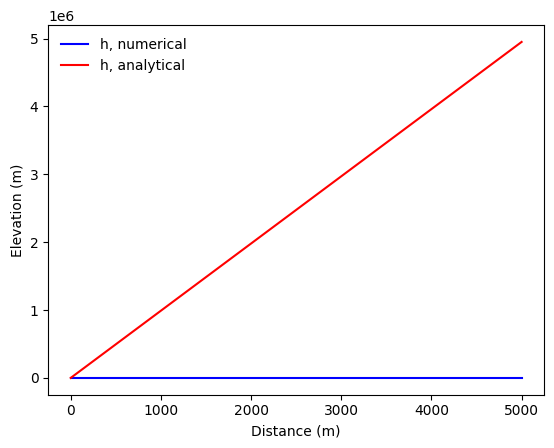

In [37]:
# set up a figure with one panel
fig, panel = pl.subplots(1, 1)

# plot the numerical solution
panel.plot(x, h, color='blue', label='h, numerical')

# and the analytical solution, add the right variables and uncomment (remove #) the next line:
panel.plot(x, h_an, color='red', label='h, analytical')

# make the figure nicer:
panel.set_xlabel('Distance (m)')
panel.set_ylabel('Elevation (m)')
panel.legend(loc='upper left', fontsize='medium', frameon=False)

fig.savefig('simulated_h.png')

You result should show two lines, one the analytical and one the numerical. If you did not change n_iterations, the numerical line will probably be below your analytical line. That means that we did not have enough iterations to come to a steady value. We will fix this problem later.

## Making the code faster
For loops in general make your code relatively slow. We can use numpy's functionality to avoid the inner for loop that cycles over the grid cells and try to calculate the new value of `h` for all nodes in one go at each timestep. We will implement the faster code in a new function called ``solve_steady_state_diffusion_eq_faster`` which you can find at the start of the notebook.

For this we need to remove the inner for loop (remove the line ``for i in range(n_nodes):``, and unindent the lines in this for loop) and replace the equations for `h`. The two lines for the boundary conditions can remain the same, since they do not depend on the value of ``i``, which tracks the node number. For all the nodes in between the boundary conditions, we can calculate `h` like this:

~~~~python
h_new[1:-1] = ... a function of C[1:-1], h_old[2:] and h_old[:-2]
~~~~

In this piece of code ``h_new[1:-1]`` means all grid cells except the first and last ones. ``h_old[2:]`` means all grid cells, except the first two, and ``h_old[:-2]`` means all grid cells except the last two. This statement does exactly the same as our for loop earlier, but many times faster.

After you are done with changing the code try to run the new faster model using the code below.

In [38]:
def solve_steady_state_diffusion_eq_faster(dx, K, W, h0, n_iterations=1000):

    """
    this is a function where we will solve the steady-state diffusion equation
    for groundwater or heat flow

    this function receives 4 variables from the main code: dx, K, W, u0
    plus an optional variable n_iterations. The default value for this
    variable if not specified otherwise is 1000

    """

    # check the number of nodes in our numerical model:
    n_nodes = len(W)

    # set u an array to store the variable (ie, hydraulic head or temperature)
    h_new = np.full(n_nodes, h0)

    # and set up a similar array to store the variable value of the previous
    # iteration step
    h_old = h_new.copy()

    # calculate the right hand term of the finite difference equation:
    C = W * dx**2 / K

    # set up a for loop to repeat the calculation n_iterations times
    for n_iter in range(n_iterations):

        # complete the next line and remove the comment sign (#)

        # left boundary: fixed head
        h_new[0] = h0 # interior nodes (vectorized)

        # add the equation for the middle nodes here:
        #h_new[1:-1] = ..... a function of C[1:-1], h_old[2:], h_old[:-2]
        h_new[1:-1] = (h_old[:-2] + h_old[2:] + C[1:-1]) / 2

        # complete the next line, # right boundary: no-flow
        #h_new[-1] = .... a function of h_new[-2]
        h_new[-1] = h_new[-2]


        # copy the new u into the u array for the previous timestep:
        h_old = h_new.copy()

    # done, you can now pass on the calculated value of u back to the main
    # part of the code:
    return h_new

In [ ]:
h_faster = solve_steady_state_diffusion_eq_faster(dx, K, W_array, h0)

**Assignment 2:**
Implement the new faster code and run the numerical model again, and make a figure of the new results.

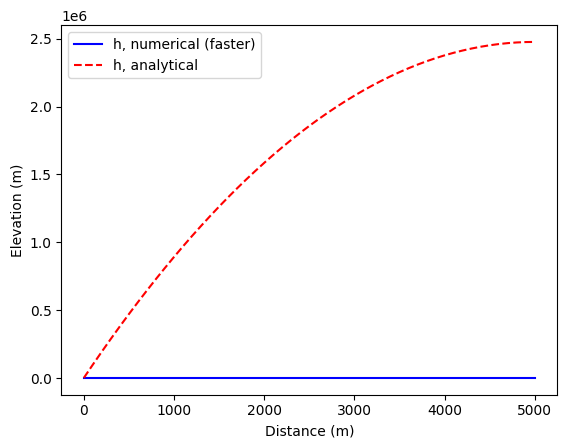

In [39]:
# add the code to plot the results of the faster function and compare it to the previous solution here:
# run the faster solver
h_faster = solve_steady_state_diffusion_eq_faster(dx, K, W_array, h0)

# analytical solution
h_an = h0 + (R * b / K) * (L * x - 0.5 * x**2)

# make the figure
fig, panel = pl.subplots(1, 1)

# numerical (faster)
panel.plot(x, h_faster, color='blue', label='h, numerical (faster)')

# analytical
panel.plot(x, h_an, color='red', linestyle='--', label='h, analytical')

# labels and legend
panel.set_xlabel('Distance (m)')
panel.set_ylabel('Elevation (m)')
panel.legend(loc='upper left')


In the previous runs we have not specified the amount or runs. If we do not tell the model n_iterations=, when we call on the function, the amount of iterations is by default a 1000.

We are intrested in the number of iterations which is needed to get a result until the final solution does not change. To know how much the value changes per iteration, we need to calculate the difference with the previous iteration, we can do that as follows:

~~~~python
error = np.max(np.abs(h_new - h_old))
~~~~

This should be place before the line:

~~~~python
h_old = h_new.copy()
~~~~

Next, we can add a statement, that when the error is smaller then what we need it to be, it stops the code and returns the iteration round it was on. To do this we can use the command 'break'. That will look something like this:

~~~~python
if error<0.01:
  print(n_iter)
  break    
~~~~




Copy and past your `solve_steady_state_diffusion_eq_faster` code below and make the changes as described above. Do not forget to increase the amount of `n_iterations` when running the code.

In [42]:
# paste your code here
def solve_steady_state_diffusion_eq_faster(dx, K, W, h0, n_iterations=50000):

    n_nodes = len(W)

    h_new = np.full(n_nodes, h0)
    h_old = h_new.copy()

    C = W * dx**2 / K

    for n_iter in range(n_iterations):

        # left boundary: fixed head
        h_new[0] = h0

        # interior nodes (vectorized update)
        h_new[1:-1] = (h_old[:-2] + h_old[2:] + C[1:-1]) / 2

        # right boundary: no-flow
        h_new[-1] = h_new[-2]

        # compute error BEFORE overwriting h_old
        error = np.max(np.abs(h_new - h_old))

        # stopping criterion
        if error < 0.01:
            print("Converged after", n_iter, "iterations")
            break

        # update for next iteration
        h_old = h_new.copy()

    return h_new



In [46]:
# run the code here
h_faster = solve_steady_state_diffusion_eq_faster(dx, K, W_array, h0)

Converged after 0 iterations


**Assignment 3:** How many timesteps do you need to have an error or *h* that is less than 1 cm?

## Automated model calibration

One of the advantages of Python is that over the last two decades or so a lot of people have written a huge variety of Python modules that add all kinds of different useful functionality. One such module is called Scipy, <http://www.scipy.org>. This is a large collection of mathematical and scientific functions. Scipy contains a set of functions that deal with model calibration. We will use this to calibrate hydraulic conductivity in our numerical model. This is of course much faster and convenient than adjusting the values by hand as you've done in exercise 1.

The automated calibration module needs a second function that compares the modelled value of ``h`` to an observed value and then returns the model error. This function looks like this:

In [47]:
def model_error(params, dx, W, h0, h_obs):

    K = params[0]

    # calculate the model predicted value of h
    h_pred = solve_steady_state_diffusion_eq(dx, K, W, h0)

    # calculate the absolute error between model and observed h
    h_error = np.abs(h_pred[-1] - h_obs)

    return h_error

As you can see this function runs the model first and then calculates the absolute difference between *h* at the right hand node (``h_pred[-1]``) and some observed value ``h_obs``. The variable ``params`` is a list that contains all the parameters that we want to calibrate automatically. In this case we only calibrate ``K``, so ``params`` can be a list with only one value. We use the absolute model error, since the calibration function that we use is a functions that tries to minimise a value, ie.: it runs the function ``model_error`` again and again to find the lowest value of ``h_error``.

Now all we need to run automatic calibration is to call one of scipy's automatic calibration functions in the main code:

note that ``h_obs`` is the observed value of ``h`` at the right hand side of the model domain/the watershed boundary.

In [48]:
h_obs = 350.0
params = [K]
params_calibrated = opt.fmin(model_error, params, args=(dx, W_array, h0, h_obs))
K_calibrated = params_calibrated[0]

print('new calibrated value of K = ', K_calibrated)

Optimization terminated successfully.
         Current function value: 100.000000
         Iterations: 1
         Function evaluations: 2
new calibrated value of K =  1e-05


now we rerun the numerical model with the updated value of K:

In [49]:
h_calibrated = solve_steady_state_diffusion_eq_faster(dx, K_calibrated, W_array, h0)

Converged after 0 iterations


**Assignment 4:** Run the model with the new automatic calibration function. Check if the calibrated value of ``K`` is close to the value you calibrated manually in exercise 1. Use the new value of ``K`` to model hydraulic head and make a figure of this.


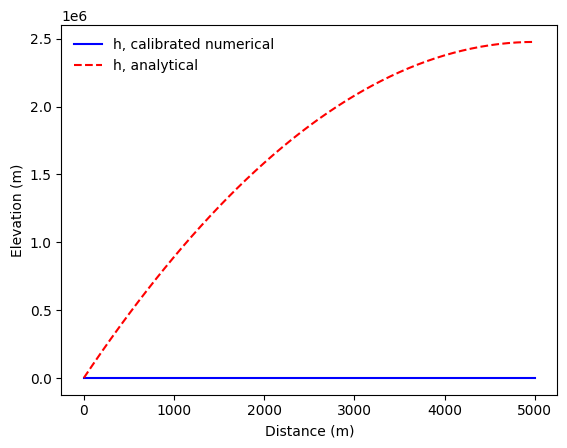

In [50]:
# add the plot code here to compare the calibrated model with the observed value of h
fig, panel = pl.subplots(1, 1)

# numerical solution with calibrated K
panel.plot(x, h_calibrated, color='blue', label='h, calibrated numerical')

# analytical solution for comparison
h_an = h0 + (R * b / K_calibrated) * (L * x - 0.5 * x**2)
panel.plot(x, h_an, color='red', linestyle='--', label='h, analytical')

panel.set_xlabel('Distance (m)')
panel.set_ylabel('Elevation (m)')
panel.legend(loc='upper left', fontsize='medium', frameon=False)


## Done!

Congrats, you just managed to write your first groundwater model in Python. We will make this model more realistic in the next weeks by making it dynamic and allowing changes over time.